# 4장 실제 데이터를 텐서로 표현해보기

## 4.1 이미지 다루기

In [6]:
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, threshold=50)

In [4]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


imageio로 png이미지를 로딩할 수 있다, 로딩된 이미지는 너비, 높이, 채널(RGB) 세개의 차원을 가진다

In [7]:
import imageio

img_arr = imageio.imread('data/p1ch4/image-dog/bobby.jpg')
img_arr.shape

C:\Users\HS\AppData\Local\Temp\ipykernel_13444\1689007281.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_arr = imageio.imread('data/p1ch4/image-dog/bobby.jpg')


(720, 1280, 3)

하지만 파이토치 모듈은 텐서가 (채널, 높이, 너비) 순으로 배치되어야 한다. tensor.permute()으로 차원을 바꿀 수 있다

In [11]:
img = torch.from_numpy(img_arr)
out = img.permute(2, 0, 1)

In [13]:
out.shape

torch.Size([3, 720, 1280])

이제 채널이 3, 높이 256, 너비 256의 이미지가 3개 있는 배치를 만들어보자. 여기서 데이터 타입은 부호가 없는 8비트 정수로 표현된다.

In [14]:
batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)

이제 파일에 있는 png 파일을 읽어와 텐서로 변환해보자

In [15]:
import os

data_dir = 'data/p1ch4/image-cats/'
filenames = [name for name in os.listdir(data_dir)
             if os.path.splitext(name)[-1] == '.png']
for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2, 0, 1)
    img_t = img_t[:3] # <1>투명도가 있는 이미지는 4번쨰 요소까지 있지만, 우리는 RGB만 사용함으로 첫 세개 채널만 유지
    batch[i] = img_t

C:\Users\HS\AppData\Local\Temp\ipykernel_13444\4009713087.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_arr = imageio.imread(os.path.join(data_dir, filename))


신경망은 입력값이 0부터1 사이이거나 -1부터1사이일때 훈련 성능이 가장 좋다. 그러므로 RGB값의 최대치인 255로 전부 나눠주어 정규화를 해주자

In [17]:
batch = batch.float()
batch /= 255.0

혹은 각 채널의 평균과 표준 편차를 구해서 평균이 0이고 각 채널값이 표준 편차가 되도록 정규화할 수 있다

In [18]:
n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std

## 3차원 이미지: 용적 데이터

image.volread 함수는 인자로 받은 디렉토리에 있는 의료용 디지털 영상 파일을 연속된 형태로 조합해서 3차원 넘파이 배열을 만든다

In [20]:
import imageio

dir_path = "data/p1ch4/volumetric-dicom/2-LUNG 3.0  B70f-04083"
vol_arr = imageio.volread(dir_path, 'DICOM')
vol_arr.shape

Reading DICOM (examining files): 1/99 files (1.0%17/99 files (17.2%34/99 files (34.3%52/99 files (52.5%69/99 files (69.7%88/99 files (88.9%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 33/99  (33.371/99  (71.799/99  (100.0%)


(99, 512, 512)

torch.from_numpy로 넘파이 배열을 텐서로 변환하고, 실수 형태로 저장한다. 채널 정보가 사라져서 레이아웃이 달라졌으니 unsqueeze 함수로 채널 차원을 위한 공간을 만들어준다

In [21]:
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)

vol.shape

torch.Size([1, 99, 512, 512])

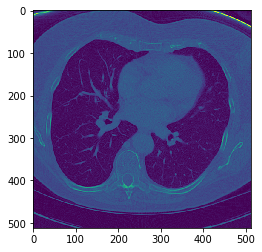

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(vol_arr[50])

## 4.3테이블 데이터 표현하기

CSV나 Excel 형태로 되어있는 테이블 데이터를 부동소수점 수로 이뤄진 텐서로 나타낼 수 있다. 밑 데이터는 와인에 대한 화학성분을 나타낸 테이블 데이터고, 각 와인에 대한 맛의 점수가 타겟인 데이터다. 이 데이터셋에 대해 실행한 머신러닝 작업은 화학 성분만 가지고 맛을 예측하는 것이다. 넘파이를 이용해 csv 파일을 불러오고 텐서로 저장해보자.

In [23]:
import csv
wine_path = "data/p1ch4/tabular-wine/winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";",
                         skiprows=1)
wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

csv.reader로 첫 번째 줄 카테고리들을 출력할 수 있다

In [26]:
col_list = next(csv.reader(open(wine_path), delimiter=';'))

wineq_numpy.shape, col_list

((4898, 12),
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'])

넘파이 배열을 from_numpy로 텐서로 바꿔준다.

In [27]:
wineq = torch.from_numpy(wineq_numpy)

wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

품질 점수를 연속값으로 취급해서 회귀 작업을 할 수도 있고, 레이블로 취급해서 분류 작업을 할수도 있겠다(1점, 2점, 3점 등으로). 두 가지 경우 모두 점수를 정답 값으로 쓸 수 있다

In [33]:
data = wineq[:, :-1] # <1> 모든 행과 마지막을 제외한 모든 열 선택(마지막 열은 정답 값)
data, data.shape

(tensor([[ 7.0000,  0.2700,  ...,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  ...,  0.4900,  9.5000],
         ...,
         [ 5.5000,  0.2900,  ...,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  ...,  0.3200, 11.8000]]),
 torch.Size([4898, 11]))

In [35]:
target = wineq[:, -1] # <2>모든 행과 마지막 열 선택, 타겟 데이터 설정
target, target.shape

(tensor([6., 6.,  ..., 7., 6.]), torch.Size([4898]))

카테고리로 분류할거면 long() 데이터 타입으로 설정해서 정수인 점수 카테고리로 회귀 문제로 푼다

In [38]:
target = wineq[:, -1].long()
target

tensor([6, 6,  ..., 7, 6])

만약 점수가 순서가 없으며 서로 간에 완전히 이산적인 관계라면 원핫 인코딩으로 나타내도 된다. 원핫 인코딩은 정답 레이블 하나를 제외하고 전부 0으로 나타낸 벡터다. scatter 함수로 타겟 데이터를 원핫 인코딩 할 수 있다

밑 scatter_은 target_onehot을 scatter로 원핫 인코딩으로 텐서를 변경한다는 것이고, 안에 있는 인자의 값은 target 안에 있는 점수에 해당하는 인덱스 값을 1.0으로 설정한다는 뜻이다

In [39]:
target_onehot = torch.zeros(target.shape[0], 10)
target_onehot.scatter_(1, target.unsqueeze(1), 1.0)#뒤에 오는 두개의 인자가 따라야하는 차원, 원핫으로 인코딩할 요소를 
                                                #가리키는 인덱스가 들어있는 텐서, 원핫 인코딩할 원소가 들어있는 텐서/스칼라

tensor([[0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.],
        ...,
        [0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.]])

target_onehot이 4898x10의 차원이므로 target.unsqueeze(1)로 target에 추가 차원을 만들어주고 원핫 인코딩을 해준다

In [42]:
target_unsqueezed = target.unsqueeze(1)
target_unsqueezed

tensor([[6],
        [6],
        ...,
        [7],
        [6]])

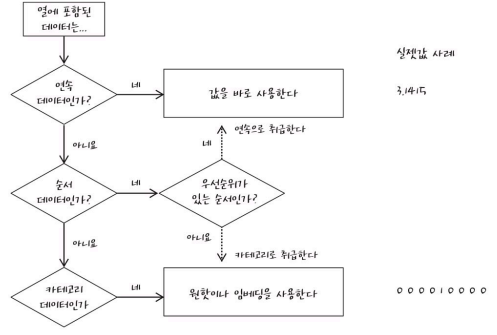

데이터를 연속으로 취급할 것인지 카테고리로 취급할 것인지에 대하여, 위와 같은 로직을 떠올리면 결정하기 쉬울 것 같다

텐서 API를 이용해서 텐서의 각 열의 평균과 표준 편차를 구할 수 있다

In [40]:
data_mean = torch.mean(data, dim=0)
data_mean

tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01])

In [43]:
data_var = torch.var(data, dim=0)
data_var

tensor([7.1211e-01, 1.0160e-02, 1.4646e-02, 2.5726e+01, 4.7733e-04, 2.8924e+02,
        1.8061e+03, 8.9455e-06, 2.2801e-02, 1.3025e-02, 1.5144e+00])

각 열의 모든 원소에 해당하는 평균을 빼준 값을 표준 편차로 나눠줌으로써 정규화시켜준다

In [44]:
data_normalized = (data - data_mean) / torch.sqrt(data_var)
data_normalized

tensor([[ 1.7208e-01, -8.1761e-02,  ..., -3.4915e-01, -1.3930e+00],
        [-6.5743e-01,  2.1587e-01,  ...,  1.3422e-03, -8.2419e-01],
        ...,
        [-1.6054e+00,  1.1666e-01,  ..., -9.6251e-01,  1.8574e+00],
        [-1.0129e+00, -6.7703e-01,  ..., -1.4882e+00,  1.0448e+00]])

혹은 입계값으로 나쁜 와인 좋은 와인을 구별할 수 있다. 나쁜 와인은 점수가 3 이하인 값이라고 설정하자.

In [45]:
bad_indexes = target <= 3 # <1>텐서에 바로 비교 연산자를 통해 불리언 텐서를 만들 수 있다
bad_indexes.shape, bad_indexes.dtype, bad_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(20))

In [46]:
bad_data = data[bad_indexes]
bad_data.shape

torch.Size([20, 11])

이제 와인을 좋음, 보통, 나쁨 카테고리로 나눌 수 있다. 이제 각 카테고리의 평균치를 구한 다음에 각 열에 따른 평균값을 출력해보자

In [47]:
bad_data = data[target <= 3]
mid_data = data[(target > 3) & (target < 7)] # <1>
good_data = data[target >= 7]

bad_mean = torch.mean(bad_data, dim=0)
mid_mean = torch.mean(mid_data, dim=0)
good_mean = torch.mean(good_data, dim=0)

for i, args in enumerate(zip(col_list, bad_mean, mid_mean, good_mean)):
    print('{:2} {:20} {:6.2f} {:6.2f} {:6.2f}'.format(i, *args))

 0 fixed acidity          7.60   6.89   6.73
 1 volatile acidity       0.33   0.28   0.27
 2 citric acid            0.34   0.34   0.33
 3 residual sugar         6.39   6.71   5.26
 4 chlorides              0.05   0.05   0.04
 5 free sulfur dioxide   53.33  35.42  34.55
 6 total sulfur dioxide 170.60 141.83 125.25
 7 density                0.99   0.99   0.99
 8 pH                     3.19   3.18   3.22
 9 sulphates              0.47   0.49   0.50
10 alcohol               10.34  10.26  11.42


한눈에 봐도 나쁜 와인은 total sulfur dioxide(이산화황)이 높아 보인다. 와인을 평가하기 위해 이산화황 총량을 임계값으로 사용해보자. 이산화황의 중앙값인 141.83이고 이보다 낮은 인덱스만 가져와보자.

In [49]:
total_sulfur_threshold = 141.83
total_sulfur_data = data[:,6]
predicted_indexes = torch.lt(total_sulfur_data, total_sulfur_threshold)

predicted_indexes.shape, predicted_indexes.dtype, predicted_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(2727))

이제 점수가 5보다 높은 좋은 와인이랑 비교해보자. 임계값으로 예측한 수량보다 좋은 와인이 500개나 더 많은 것을 보아 완벽하지 않은 것이 증명되었다. 

In [50]:
actual_indexes = target > 5

actual_indexes.shape, actual_indexes.dtype, actual_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(3258))

이제 &연산자를 이용해 이산화황으로 예측한 결과를 평가해보자. 2000개 가량을 맞췄으니, 74%의 확률로 고품질의 와인을 골라 낼 수 있게 되었다. 

In [51]:
n_matches = torch.sum(actual_indexes & predicted_indexes).item()
n_predicted = torch.sum(predicted_indexes).item()
n_actual = torch.sum(actual_indexes).item()

n_matches, n_matches / n_predicted, n_matches / n_actual

(2018, 0.74000733406674, 0.6193984039287906)

## 4.4 시계열 데이터

아래 데이터는 시간대별로 자전거가 대여된 데이터를 나타낸다. 순서가 있는 데이터기 때문에, 단순하게 데이터 순서를 무시할 수 없다

In [48]:
bikes_numpy = np.loadtxt(
    "data/p1ch4/bike-sharing-dataset/hour-fixed.csv", 
    dtype=np.float32, 
    delimiter=",", 
    skiprows=1, 
    converters={1: lambda x: float(x[8:10])}) # <1>첫번째 열의 일자 문자열을 숫자로 반환
bikes = torch.from_numpy(bikes_numpy)
bikes

tensor([[1.0000e+00, 1.0000e+00,  ..., 1.3000e+01, 1.6000e+01],
        [2.0000e+00, 1.0000e+00,  ..., 3.2000e+01, 4.0000e+01],
        ...,
        [1.7378e+04, 3.1000e+01,  ..., 4.8000e+01, 6.1000e+01],
        [1.7379e+04, 3.1000e+01,  ..., 3.7000e+01, 4.9000e+01]])

17520시간에 17개의 열이다. 17개의 열은 섭씨 기온, 습도 등이다. 열은 17개이기 때문에 stride가 (17, 1)인 걸 알 수 있다

In [3]:
bikes.shape, bikes.stride()

(torch.Size([17520, 17]), (17, 1))

일별로 나타내야 하기 때문에 24시간 배치로 바라보는 뷰가 필요하다. view 함수로 행을 24로 바꿔주고, -1로 남은 값을 0차원에 넣어준다.

In [4]:
daily_bikes = bikes.view(-1, 24, bikes.shape[1])
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 24, 17]), (408, 17, 1))

In [5]:
daily_bikes = daily_bikes.transpose(1, 2)
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 17, 24]), (408, 1, 17))

날씨를 기준으로 할떄, 1은 좋은 날씨 4는 아주 안좋은 날씨다. 이를 카테고리로 보려면 원핫 인코딩 벡터로 만들어야 한다.

In [6]:
first_day = bikes[:24].long()
weather_onehot = torch.zeros(first_day.shape[0], 4)
first_day[:,9]

tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2,
        2, 2])

unsqueeze로 싱글톤 차원을 더해준다. (한 행이 하나의 타겟 값에 대응되기 때문에 차원을 하나 늘려줘야 한다). 

In [7]:
weather_onehot.scatter_(
    dim=1, 
    index=first_day[:,9].unsqueeze(1).long() - 1, # <1> 날씨는 1부터 4지만 인덱스는 0에서 시작함으로 -1
    value=1.0)

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])

cat 함수로 원래 있던 데이터셋에 concatenate을 해준다

In [8]:
torch.cat((bikes[:24], weather_onehot), 1)[:1]

tensor([[ 1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          6.0000,  0.0000,  1.0000,  0.2400,  0.2879,  0.8100,  0.0000,
          3.0000, 13.0000, 16.0000,  1.0000,  0.0000,  0.0000,  0.0000]])

In [9]:
daily_weather_onehot = torch.zeros(daily_bikes.shape[0], 4,
                                   daily_bikes.shape[2])
daily_weather_onehot.shape

torch.Size([730, 4, 24])

In [10]:
daily_weather_onehot.scatter_(
    1, daily_bikes[:,9,:].long().unsqueeze(1) - 1, 1.0)
daily_weather_onehot.shape

torch.Size([730, 4, 24])

In [11]:
daily_bikes = torch.cat((daily_bikes, daily_weather_onehot), dim=1)

In [12]:
daily_bikes[:, 9, :] = (daily_bikes[:, 9, :] - 1.0) / 3.0

앞에서 설명한 바와 같이 변수를 0부터 1 or -1부터 1 사잇값으로 가지는게 좋기 때문에 min, max로 맞춰주거나 평균 뺴주기 나누기 표준오차로 정규화를 해줄 수 있다

In [13]:
temp = daily_bikes[:, 10, :]
temp_min = torch.min(temp)
temp_max = torch.max(temp)
daily_bikes[:, 10, :] = ((daily_bikes[:, 10, :] - temp_min)
                         / (temp_max - temp_min))

In [14]:
temp = daily_bikes[:, 10, :]
daily_bikes[:, 10, :] = ((daily_bikes[:, 10, :] - torch.mean(temp))
                         / torch.std(temp))

## 4.5 텍스트 표현하기

NLP(자연어 처리)는 텍스트를 숫자로 변환해야 한다. 아래 데이터는 제인 오스틴의 오만과 편견이다.

In [4]:
with open('data/p1ch4/jane-austen/1342-0.txt', encoding='utf8') as f:
    text = f.read()

엔터를 기준으로 split해준 값이다. 문장을 split해주었다.  

In [5]:
lines = text.split('\n')
line = lines[200]
line

'“Impossible, Mr. Bennet, impossible, when I am not acquainted with him'

행 전체의 문자를 원핫 인코딩한 문자의 총수를 담을 텐서를 만들자

In [7]:
letter_t = torch.zeros(len(line), 128) # <1> 아스키 제한인 128로 하드코딩
letter_t.shape

torch.Size([70, 128])

이제 각 letter를 아스키코드에 따라 원핫 인코딩 해준다

In [5]:
for i, letter in enumerate(line.lower().strip()):
    letter_index = ord(letter) if ord(letter) < 128 else 0  # <1>
    letter_t[i][letter_index] = 1

clean_words는 텍스트를 받아 소문자로 만들고 구두점을 날리는 함수다

In [6]:
def clean_words(input_str):
    punctuation = '.,;:"!?”“_-'
    word_list = input_str.lower().replace('\n',' ').split()
    word_list = [word.strip(punctuation) for word in word_list]
    return word_list

words_in_line = clean_words(line)
line, words_in_line

('“Impossible, Mr. Bennet, impossible, when I am not acquainted with him',
 ['impossible',
  'mr',
  'bennet',
  'impossible',
  'when',
  'i',
  'am',
  'not',
  'acquainted',
  'with',
  'him'])

word2index_dict는 단어를 키로, 정수를 값으로 가지는 딕셔너리다. 나중에 단어에 대한 인덱스를 찾을 때 해싱을 이용한 원리인 것 같다. 

In [7]:
word_list = sorted(set(clean_words(text)))
word2index_dict = {word: i for (i, word) in enumerate(word_list)}

len(word2index_dict), word2index_dict['impossible']

(7261, 3394)

In [8]:
word_t = torch.zeros(len(words_in_line), len(word2index_dict))
for i, word in enumerate(words_in_line):
    word_index = word2index_dict[word]
    word_t[i][word_index] = 1
    print('{:2} {:4} {}'.format(i, word_index, word))
    
print(word_t.shape)


 0 3394 impossible
 1 4305 mr
 2  813 bennet
 3 3394 impossible
 4 7078 when
 5 3315 i
 6  415 am
 7 4436 not
 8  239 acquainted
 9 7148 with
10 3215 him
torch.Size([11, 7261])


In [9]:
word_t = word_t.unsqueeze(1)
word_t.shape

torch.Size([11, 1, 7261])

In [10]:
[(c, ord(c)) for c in sorted(set(text))]


[('\n', 10),
 (' ', 32),
 ('!', 33),
 ('#', 35),
 ('$', 36),
 ('%', 37),
 ("'", 39),
 ('(', 40),
 (')', 41),
 ('*', 42),
 (',', 44),
 ('-', 45),
 ('.', 46),
 ('/', 47),
 ('0', 48),
 ('1', 49),
 ('2', 50),
 ('3', 51),
 ('4', 52),
 ('5', 53),
 ('6', 54),
 ('7', 55),
 ('8', 56),
 ('9', 57),
 (':', 58),
 (';', 59),
 ('?', 63),
 ('@', 64),
 ('A', 65),
 ('B', 66),
 ('C', 67),
 ('D', 68),
 ('E', 69),
 ('F', 70),
 ('G', 71),
 ('H', 72),
 ('I', 73),
 ('J', 74),
 ('K', 75),
 ('L', 76),
 ('M', 77),
 ('N', 78),
 ('O', 79),
 ('P', 80),
 ('Q', 81),
 ('R', 82),
 ('S', 83),
 ('T', 84),
 ('U', 85),
 ('V', 86),
 ('W', 87),
 ('X', 88),
 ('Y', 89),
 ('Z', 90),
 ('[', 91),
 (']', 93),
 ('_', 95),
 ('a', 97),
 ('b', 98),
 ('c', 99),
 ('d', 100),
 ('e', 101),
 ('f', 102),
 ('g', 103),
 ('h', 104),
 ('i', 105),
 ('j', 106),
 ('k', 107),
 ('l', 108),
 ('m', 109),
 ('n', 110),
 ('o', 111),
 ('p', 112),
 ('q', 113),
 ('r', 114),
 ('s', 115),
 ('t', 116),
 ('u', 117),
 ('v', 118),
 ('w', 119),
 ('x', 120),
 ('y',

## 4.7 연습 문제

1. 빨간색, 파란색, 초록색 물건을 찍은 사진을 준비해라\
a. 각이미지를 읽어 텐서로 변환해라

In [8]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [11]:
import imageio
red = imageio.imread("red.jpg")
blue = imageio.imread("blue.jfif")
green = imageio.imread("green.jfif")

C:\Users\HS\AppData\Local\Temp\ipykernel_13156\2870309030.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  red = imageio.imread("red.jpg")
C:\Users\HS\AppData\Local\Temp\ipykernel_13156\2870309030.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  blue = imageio.imread("blue.jfif")
C:\Users\HS\AppData\Local\Temp\ipykernel_13156\2870309030.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` 

In [27]:
red

Array([[[255, 245, 255],
        [255, 248, 255],
        [255, 251, 252],
        ...,
        [249, 253, 255],
        [255, 250, 255],
        [255, 246, 255]],

       [[255, 248, 254],
        [255, 254, 255],
        [248, 255, 255],
        ...,
        [244, 255, 255],
        [254, 255, 255],
        [255, 247, 255]],

       [[251, 255, 254],
        [247, 255, 255],
        [236, 255, 251],
        ...,
        [238, 255, 254],
        [248, 255, 255],
        [255, 251, 255]],

       ...,

       [[236, 255, 255],
        [242, 255, 255],
        [241, 255, 255],
        ...,
        [252, 250, 251],
        [255, 255, 255],
        [255, 255, 255]],

       [[246, 254, 255],
        [251, 255, 255],
        [251, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [250, 250, 250]],

       [[255, 253, 255],
        [255, 250, 255],
        [255, 252, 255],
        ...,
        [252, 252, 252],
        [253, 253, 253],
        [255, 255, 255]]

b. 각 이미지 텐서에 대해 .mean() 메소드를 이용해 이미지가 얼마나 밝은지 확인해라

In [21]:
red_bright = red[:, ].mean()
blue_bright = blue[:, ].mean()
green_bright = green[:, ].mean()

In [22]:
red_bright

55.38684468283582

In [23]:
blue_bright

135.2259635925293

In [24]:
green_bright

89.04596054080591

c. 이미지 각 채널 평균을 구해보라. 채널의 평균값만으로 빨간색, 파란색, 초록색을 구분 가능한가?

In [30]:
for i in range(3):
    print(red[:, :,  i].mean())

111.75451026119403
20.930757929104477
33.47526585820896


In [32]:
for i in range(3):
    print(blue[:, :,  i].mean())

121.00564956665039
129.4054183959961
155.2668228149414


In [31]:
for i in range(3):
    print(green[:, :,  i].mean())

29.73432711061577
141.7751661823827
95.62838832941925


RGB이므로 제일 각각 이미지의 색에 맞춰 RGB 값이 높게 나오기 때문에 구분 가능하다